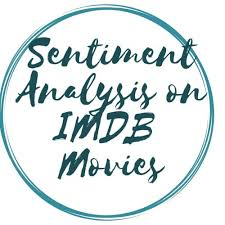

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
Image(filename='./images/imdb.jpeg')

### Objective :  
- We will build a deep learning model to detect sentiment (i.e. detect if a sentence is positive or negative) using PyTorch and TorchText
-  This will be done on movie reviews, using the IMDb dataset.


### Introduction to RNN :
- **Recurrent neural network (RNN) are commonly used in analysing sequences**
- **An RNN takes in sequence of words one at a time and produces a hidden state for each word.**
- **We use the RNN recurrently by feeding in the current word as well as the hidden state from the previous word to produce th next hidden state.**

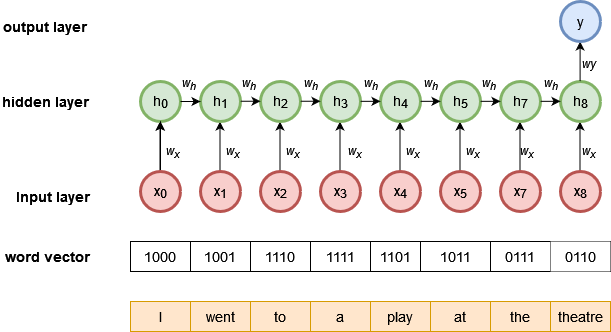

In [2]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
Image(filename='./images/rnn.png')

Once we have our final hidden state from feeding in the last word in the sequence,we feed it through a linear layer(also known as a fully connected layer), to receive our predicted sentiment, 


####  Importing libraries

In [3]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')
LABEL = data.LabelField(dtype = torch.float)

- In torchtext `Field` defines how our data should be processed.
- Our `TEXT` field has tokenize='spacy' as an argument, that defines tokenization should be done using spacy tokenizer.
- We also need to specify a `tokenizer_language` which tells torchtext which spaCy model to use.
- We will use `en_core_web_sm model` which has to be downloaded with python -m spacy download en_core_web_sm.
- LABEL is defined by a `LabelField`, a special subset of the Field class specifically used for handling labels.

In [5]:
from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [6]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [7]:
import random
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


#### Build a vocabulary
- This is a effectively a look up table where every unique word in your data set has a corresponding index 
- The number of unique words in our training set is over 100,000, which means that our one-hot vectors will have over 100,000 dimensions! This will make training slow and possibly won't fit onto your GPU
- we can either only take the top most common words or ignore words that appear less than m times, hence we will only keeping the top 25,000 words.
- What do we do with words that appear in examples but we have cut from the vocabulary? We replace them with a special unknown or <unk> token.

In [9]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [10]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


#### View the most common words in the vocabulary and their frequencies

In [11]:
print(TEXT.vocab.freqs.most_common(10))

[('the', 203566), (',', 192495), ('.', 165544), ('and', 109443), ('a', 109116), ('of', 100702), ('to', 93766), ('is', 76328), ('in', 61255), ('I', 54004)]


In [12]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [13]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


#### The final step of preparing the data is creating the iterators
- We'll use a BucketIterator which is a special type of iterator that will return a batch of examples where each example is of a similar length, minimizing the amount of padding per example.

In [14]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

#### Build the Model

Within the `__init__` we define the layers of the module. Our three layers are an embedding layer, our RNN, and a linear layer. All layers have their parameters initialized to random values.
- 1.`Embedding layer` -  The embedding layer is used to transform our sparse one-hot vector (sparse as most of the elements are 0) into a dense embedding vector (dense as the dimensionality is a lot smaller and all the elements are real numbers). This embedding layer is simply a single fully connected layer. As well as reducing the dimensionality of the input to the RNN.
- 2.`RNN Layer` - The RNN layer is our RNN which takes in our dense vector and the previous hidden state H(t-1) which it used to calculate the next hidden state H(t).
- 3.`Linear Layer` -  The linear layer takes the final hidden state and feeds it through a fully connected layer then transforming it to the correct output dimension.

In [15]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

- The forward method is called when we feed examples into our model.
- `text` is a tensor of size **[sentence length, batch size]**. That is a batch of sentences, each having each word converted into a one-hot vector.
- The input batch is then passed through the embedding layer to get `embedded`, which gives us a dense vector representation of our sentences. embedded is a tensor of size **[sentence length, batch size, embedding dim]**.
- `embedded` is then fed into the RNN. 
- The RNN returns 2 tensors, output of size **[sentence length, batch size, hidden dim]** and hidden of size **[1, batch size, hidden dim]**. 
- Output is the concatenation of the hidden state from every time step.
- hidden is simply the final hidden state.
- The squeeze method is used to remove a dimension of size 1.

#### Create an instance of our RNN class

In [16]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

#### Train the Model

**1. Create an optimizer**
- Optimizer is algorithm we use to update the parameters of the model.
- For this task we will use ***stochastic gradient descent (SGD)***.
- The first argument is the parameters whuich will be updated by the optimizer.
- The second argument is the learning rate i.e. how much we'll change the parameters by when we do a parameter update.

In [17]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-3)

**2. Define our loss function (In PyTorch this is commonly called a criterion)**
- We will use binary cross entropy with logits.
- Our model currently outputs an unbound real number. As our labels are either 0 or 1, we want to restrict the predictions to a number between 0 and 1. We do this using the sigmoid or logit functions.
- The BCEWithLogitsLoss criterion carries out both the sigmoid and the binary cross entropy steps.

In [18]:
criterion = nn.BCEWithLogitsLoss()

#### Move the model and the criterion on the GPU (if we have one)

In [19]:
model = model.to(device)
criterion = criterion.to(device)

In [20]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [21]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [22]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'rnn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 6m 20s
	Train Loss: 0.694 | Train Acc: 50.23%
	 Val. Loss: 0.697 |  Val. Acc: 49.56%
Epoch: 02 | Epoch Time: 6m 36s
	Train Loss: 0.693 | Train Acc: 49.85%
	 Val. Loss: 0.697 |  Val. Acc: 49.81%
Epoch: 03 | Epoch Time: 6m 47s
	Train Loss: 0.693 | Train Acc: 50.15%
	 Val. Loss: 0.697 |  Val. Acc: 50.68%
Epoch: 04 | Epoch Time: 5m 38s
	Train Loss: 0.693 | Train Acc: 49.70%
	 Val. Loss: 0.697 |  Val. Acc: 49.44%
Epoch: 05 | Epoch Time: 6m 18s
	Train Loss: 0.693 | Train Acc: 50.04%
	 Val. Loss: 0.697 |  Val. Acc: 50.59%


####  Test loss and accuracy

In [26]:
model.load_state_dict(torch.load('rnn-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.709 | Test Acc: 47.40%
